In [25]:
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Dataset Path
DATASET_PATH = "/content/drive/MyDrive/SER_Dataset/Ravdess/"
PROCESSED_DATA_DIR = "/content/drive/MyDrive/SER_Dataset/processed_data"
AUDIO_TYPES = ["Audio_Speech_Actors_01-24", "Audio_Song_Actors_01-24"]
ACTORS = [f"Actor_{i}" for i in range(1, 25)]

# Ensure processed data directories exist
for folder in ["train", "val", "test"]:
    os.makedirs(os.path.join(PROCESSED_DATA_DIR, folder), exist_ok=True)

# Emotion labels mapping
EMOTION_MAP = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import cv2


In [3]:
def load_audio(file_path):
    audio, sr = librosa.load(file_path, sr=16000)
    return audio, sr

def add_noise(audio):
    noise = np.random.normal(0, 0.005, audio.shape)
    return audio + noise

def pitch_shift(audio, sr, n_steps=2):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def extract_features(audio, sr):
    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # MFCC
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)

    # Chroma
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)

    # Resize all features to the same shape (128x128)
    mel_spec = cv2.resize(mel_spec, (128, 128))
    mfcc = cv2.resize(mfcc, (128, 128))
    chroma = cv2.resize(chroma, (128, 128))

    # Stack into a 3-channel image
    feature_img = np.stack([mel_spec, mfcc, chroma], axis=-1)

    return feature_img


In [4]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
import os
import cv2  # For resizing feature maps

# Function to Normalize Feature Maps
def normalize_features(features):
    min_val = np.min(features)
    max_val = np.max(features)
    return (features - min_val) / (max_val - min_val)  # Scale to [0,1]

def preprocess_audio(file_path):
    y, sr = librosa.load(file_path, sr=16000)

    # Extract features
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)  # Extract MFCCs

    chroma = librosa.feature.chroma_stft(y=y, sr=sr)  # Extract Chroma

    # Normalize features
    mel_spec = normalize_features(mel_spec)
    mfcc = normalize_features(mfcc)
    chroma = normalize_features(chroma)

    # Resize MFCC and Chroma to match Mel-Spectrogram shape
    target_shape = mel_spec.shape  # (128, T)
    mfcc_resized = cv2.resize(mfcc, (target_shape[1], target_shape[0]))
    chroma_resized = cv2.resize(chroma, (target_shape[1], target_shape[0]))

    # Stack as 3-channel image (H, W, 3)
    features = np.stack([mel_spec, mfcc_resized, chroma_resized], axis=-1)

    return features

def preprocess_and_save():
    root_dir = "/content/drive/MyDrive/SER_Dataset/Ravdess"
    processed_data_dir = "/content/drive/MyDrive/SER_Dataset/processed_data"

    os.makedirs(processed_data_dir, exist_ok=True)

    for category in ["Audio_Speech_Actors_01-24", "Audio_Song_Actors_01-24"]:
        category_path = os.path.join(root_dir, category)

        for actor in sorted(os.listdir(category_path)):
            actor_path = os.path.join(category_path, actor)

            # Skip if it's not a directory (fixes .DS_Store issue)
            if not os.path.isdir(actor_path):
                continue

            for file in sorted(os.listdir(actor_path)):
                if file.endswith(".wav"):
                    file_path = os.path.join(actor_path, file)

                    # Extract emotion label from filename
                    emotion_label = file.split("-")[2]  # Example: 03-01-06-01-02-01-12.wav → '06'

                    # Map emotion number to category
                    emotion_dict = {
                        "01": "neutral",
                        "02": "calm",
                        "03": "happy",
                        "04": "sad",
                        "05": "angry",
                        "06": "fearful",
                        "07": "disgust",
                        "08": "surprised",
                    }
                    emotion_label = emotion_dict.get(emotion_label, "unknown")

                    save_dir = os.path.join(processed_data_dir, emotion_label)
                    os.makedirs(save_dir, exist_ok=True)

                    # Define save path
                    save_path = os.path.join(save_dir, file.replace(".wav", ".png"))

                    # Skip processing if image already exists
                    if os.path.exists(save_path):
                        print(f"Skipping {file}, already processed.")
                        continue  # Move to next file

                    # Process and Save Features
                    features = preprocess_audio(file_path)

                    plt.imsave(save_path, features)  # Save as RGB image
                    print(f"Processed and saved: {save_path}")

preprocess_and_save()


Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/neutral/03-01-01-01-01-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/neutral/03-01-01-01-01-02-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/neutral/03-01-01-01-02-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/neutral/03-01-01-01-02-02-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-01-01-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-01-01-02-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-01-02-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-01-02-02-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-01-02-02-01-01-01.png
Processed and saved: /content/drive/MyDrive/SER_Dataset/processed_data/calm/03-

In [27]:
import shutil
import random

def split_data(source_dir, train_dir, val_dir, split_ratio=0.8):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for emotion in os.listdir(source_dir):
        emotion_path = os.path.join(source_dir, emotion)
        if not os.path.isdir(emotion_path):
            continue  # Skip non-directory files

        images = [f for f in os.listdir(emotion_path) if f.endswith(".png")]
        random.shuffle(images)

        train_count = int(len(images) * split_ratio)
        train_files, val_files = images[:train_count], images[train_count:]

        os.makedirs(os.path.join(train_dir, emotion), exist_ok=True)
        os.makedirs(os.path.join(val_dir, emotion), exist_ok=True)

        for img in train_files:
            shutil.move(os.path.join(emotion_path, img), os.path.join(train_dir, emotion, img))

        for img in val_files:
            shutil.move(os.path.join(emotion_path, img), os.path.join(val_dir, emotion, img))

# Define Paths
source_dir = "/content/drive/MyDrive/SER_Dataset/processed_data"
train_dir = "/content/drive/MyDrive/SER_Dataset/processed_data/train"
val_dir = "/content/drive/MyDrive/SER_Dataset/processed_data/val"

split_data(source_dir, train_dir, val_dir)
print("Data split completed.")


Data split completed.


In [6]:
import os

train_path = os.path.join(PROCESSED_DATA_DIR, "train")
val_path = os.path.join(PROCESSED_DATA_DIR, "val")

print("Train Subfolders:", os.listdir(train_path))
print("Validation Subfolders:", os.listdir(val_path))


Train Subfolders: ['neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised', 'train', 'val', 'test']
Validation Subfolders: ['train', 'val', 'test', 'neutral', 'calm', 'happy', 'sad', 'angry', 'fearful', 'disgust', 'surprised']


In [7]:
datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    os.path.join(PROCESSED_DATA_DIR, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="training"
)

val_generator = datagen.flow_from_directory(
    os.path.join(PROCESSED_DATA_DIR, "train"),
    target_size=(128, 128),
    batch_size=32,
    class_mode="categorical",
    subset="validation"
)


Found 1964 images belonging to 11 classes.
Found 488 images belonging to 11 classes.


In [43]:
import os
import numpy as np
import cv2
import re  # Import regex module for better extraction

# Define directories
PROCESSED_DATA_DIR = "/content/drive/MyDrive/SER_Dataset/processed_data"
TRAIN_DIR = os.path.join(PROCESSED_DATA_DIR, "train")
VAL_DIR = os.path.join(PROCESSED_DATA_DIR, "val")

# Define image size
IMG_SIZE = (128, 128)

# Emotion label mapping
emotion_dict = {
    "neutral": 0, "calm": 1, "happy": 2, "sad": 3,
    "angry": 4, "fearful": 5, "disgust": 6, "surprised": 7
}

# Function to extract actor ID from filenames
def extract_actor_id(filename):
    # Find the last number in the filename (actor ID)
    numbers = re.findall(r'\d+', filename)  # Extract all numbers
    if numbers:
        return int(numbers[-1])  # Last number should be the actor ID
    else:
        return None  # If no numbers found, return None

# Function to load data
def load_data(directory):
    features, labels, actors = [], [], []

    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)

        if not os.path.isdir(emotion_path):
            continue

        for img_file in os.listdir(emotion_path):
            if img_file.endswith(".png"):
                img_path = os.path.join(emotion_path, img_file)

                # Read and preprocess the image
                img = cv2.imread(img_path)
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0  # Normalize

                # Extract actor ID
                actor_id = extract_actor_id(img_file)
                if actor_id is None:
                    print(f"⚠️ Warning: Could not extract actor ID from {img_file}")
                    continue  # Skip files with no valid ID

                # Store data
                features.append(img)
                labels.append(emotion_dict[emotion])
                actors.append(actor_id)

    return np.array(features), np.array(labels), np.array(actors)

# Load Train & Validation Data
X_train, y_train, train_actors = load_data(TRAIN_DIR)
X_val, y_val, val_actors = load_data(VAL_DIR)

# Save extracted features
np.save("train_features.npy", X_train)
np.save("train_labels.npy", y_train)
np.save("train_actors.npy", train_actors)

np.save("val_features.npy", X_val)
np.save("val_labels.npy", y_val)
np.save("val_actors.npy", val_actors)

print(f"Train Features Shape: {X_train.shape}")
print(f"Train Labels Shape: {y_train.shape}")
print(f"Train Actors Shape: {train_actors.shape}")

print(f"Validation Features Shape: {X_val.shape}")
print(f"Validation Labels Shape: {y_val.shape}")
print(f"Validation Actors Shape: {val_actors.shape}")


Train Features Shape: (2452, 128, 128, 3)
Train Labels Shape: (2452,)
Train Actors Shape: (2452,)
Validation Features Shape: (1938, 128, 128, 3)
Validation Labels Shape: (1938,)
Validation Actors Shape: (1938,)


In [44]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Lambda, BatchNormalization
import tensorflow.keras.backend as K

# Define GeM Pooling Layer
class GeMPooling(tf.keras.layers.Layer):
    def __init__(self, p_init=3.0, **kwargs):
        super(GeMPooling, self).__init__(**kwargs)
        self.p = tf.Variable(initial_value=p_init, trainable=True, dtype=tf.float32)  # Trainable 'p'

    def call(self, inputs):
        inputs = tf.maximum(inputs, 1e-6)  # Avoid zero gradients
        pooled = K.mean(K.pow(inputs, self.p), axis=[1, 2], keepdims=False)
        return K.pow(pooled, 1.0 / self.p)

    def get_config(self):
        config = super().get_config()
        config.update({"p_init": self.p.numpy()})
        return config

# Define AlexNet Model with GeM Pooling
def AlexNet_GeM(input_shape=(128, 128, 3)):
    inputs = Input(shape=input_shape)

    # Layer 1: Conv + ReLU + MaxPool
    x = Conv2D(96, (11, 11), strides=4, activation='relu', padding='valid')(inputs)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Layer 2: Conv + ReLU + MaxPool
    x = Conv2D(256, (5, 5), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Layer 3: Conv + ReLU
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)

    # Layer 4: Conv + ReLU
    x = Conv2D(384, (3, 3), activation='relu', padding='same')(x)

    # Layer 5: Conv + ReLU + MaxPool
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((3, 3), strides=2)(x)

    # Feature Extraction: Apply GeM Pooling
    x = GeMPooling()(x)

    model = Model(inputs=inputs, outputs=x, name="AlexNet_GeM_Feature_Extractor")
    return model

# Create AlexNet feature extractor with GeM Pooling
feature_extractor = AlexNet_GeM()

# Print Model Summary
feature_extractor.summary()


Model: "AlexNet_GeM_Feature_Extractor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)          │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 30, 30, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 14, 14, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 6, 6, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 6, 6, 384)           │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 6, 6, 256)           │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 2, 2, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ ge_m_pooling_2 (GeMPooling)          │ (None, 256)                 │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,747,200 (14.29 MB)

 Trainable params: 3,747,200 (14.29 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_dir = "/content/drive/MyDrive/SER_Dataset/processed_data"
batch_size = 32
image_size = (128, 128)

# Load images for feature extraction
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory(
    os.path.join(data_dir, 'train'),
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False)

# Extract & Save Features
train_features = feature_extractor.predict(train_generator)
np.save("train_features.npy", train_features)
np.save("train_labels.npy", train_generator.classes)


Found 2452 images belonging to 11 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


77/77 ━━━━━━━━━━━━━━━━━━━━ 34s 433ms/step


In [46]:
# Load Extracted Features
X_train = np.load("train_features.npy")
y_train = np.load("train_labels.npy")

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=8)

# Define Improved MLP Classifier
mlp_model = tf.keras.Sequential([
    Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(128, activation="relu"),
    Dropout(0.3),

    Dense(8, activation="softmax")  # 8 Emotion Classes
])

# Compile Model
mlp_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

# Train MLP
mlp_model.fit(X_train, y_train, epochs=300, batch_size=32, validation_split=0.2)

# Save Model
mlp_model.save("/content/drive/MyDrive/SER_Model/mlp_classifier.h5")


Epoch 1/300


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.1870 - loss: 2.4619 - val_accuracy: 0.0000e+00 - val_loss: 2.2168
Epoch 2/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.3176 - loss: 1.8720 - val_accuracy: 0.0000e+00 - val_loss: 2.2795
Epoch 3/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3724 - loss: 1.6558 - val_accuracy: 0.0000e+00 - val_loss: 2.3599
Epoch 4/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.4198 - loss: 1.5470 - val_accuracy: 0.0000e+00 - val_loss: 2.4579
Epoch 5/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4565 - loss: 1.4928 - val_accuracy: 0.0000e+00 - val_loss: 2.5130
Epoch 6/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4674 - loss: 1.4265 - val_accuracy: 0.0000e+00 - val_loss: 2.8742
Epoch 7/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5038 - loss: 1.3211 - val_accuracy: 0.0000e+00 - val_loss: 2.7915
Epoch 8/300
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5132 - loss: 1.2846 - val_ac

In [47]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import tensorflow as tf

# Load Extracted Features & Labels
X_train = np.load("train_features.npy")
y_train = np.load("train_labels.npy")

# Convert labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=8)

# Load Saved MLP Model
mlp_model = tf.keras.models.load_model("/content/drive/MyDrive/SER_Model/mlp_classifier.h5")

# Load Actor IDs for LOSO
actors = np.load("train_actors.npy")  # Ensure this file contains actor IDs

# Initialize Leave-One-Subject-Out (LOSO) Cross-Validation
logo = LeaveOneGroupOut()
y_true_all, y_pred_all = [], []

print(" Starting LOSO Cross-Validation...")

# Perform LOSO Evaluation
for fold, (train_idx, test_idx) in enumerate(logo.split(X_train, y_train, actors), 1):
    print(f" Fold {fold}/{len(np.unique(actors))} - Leaving Out Actor {actors[test_idx][0]}")

    X_train_fold, X_test_fold = X_train[train_idx], X_train[test_idx]
    y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

    # Evaluate Model
    y_pred_fold = np.argmax(mlp_model.predict(X_test_fold), axis=1)
    y_true_fold = np.argmax(y_test_fold, axis=1)

    # Store Results
    y_true_all.extend(y_true_fold)
    y_pred_all.extend(y_pred_fold)

print("\nLOSO Cross-Validation Completed.")

# Print Evaluation Metrics
print("\n🔹 Classification Report:\n", classification_report(y_true_all, y_pred_all, digits=4))
print("🔹 Confusion Matrix:\n", confusion_matrix(y_true_all, y_pred_all))
print("🔹 Overall Accuracy:", accuracy_score(y_true_all, y_pred_all))


 Starting LOSO Cross-Validation...
 Fold 1/24 - Leaving Out Actor 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
 Fold 2/24 - Leaving Out Actor 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 Fold 3/24 - Leaving Out Actor 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 Fold 4/24 - Leaving Out Actor 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
 Fold 5/24 - Leaving Out Actor 5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 Fold 6/24 - Leaving Out Actor 6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
 Fold 7/24 - Leaving Out Actor 7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
 Fold 8/24 - Leaving Out Actor 8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
 Fold 9/24 - Leaving Out Actor 9
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
 Fold 10/24 - Leaving Out Actor 10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
 Fold 11/24 - Leaving Out Actor 11
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
 Fold 12/24 - Leaving Out Actor 12
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
 Fold 13/24 - Leaving Out Actor 13
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
 Fold 14/24 - Leaving Out Actor 14

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Overall Accuracy: 72.88%


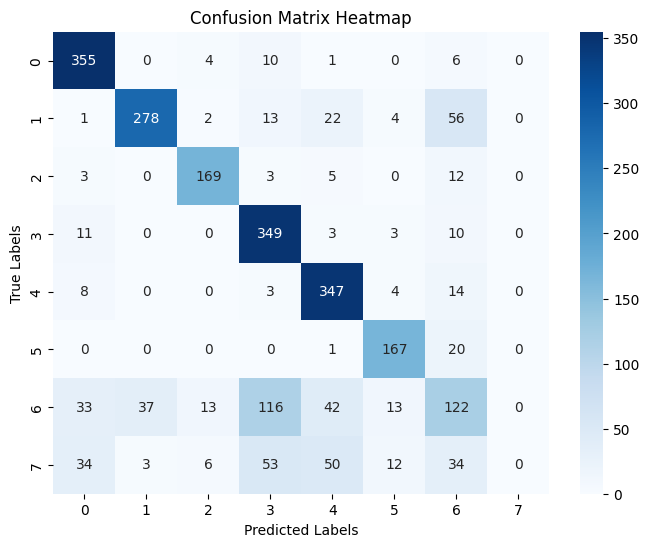

In [48]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Assuming y_true_all and y_pred_all are populated with true and predicted labels

# Overall Accuracy
overall_accuracy = accuracy_score(y_true_all, y_pred_all)
print("Overall Accuracy: {:.2f}%".format(overall_accuracy * 100))

# Plot Confusion Matrix Heatmap
cm = confusion_matrix(y_true_all, y_pred_all)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(8), yticklabels=np.arange(8))
plt.title("Confusion Matrix Heatmap")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")

# Show plot
plt.show()
